In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations, save_model_GCN
from utils import get_device, plot_training_progress
from model import GCNNetwork, CEALNetwork

from args import *
from utils import *

/root/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare the dataset

In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

Model training parameters

In [3]:
model_name = "CEAL"
model_network = model_name + "Network"
model_args = args[model_name]

In [4]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = get_device()
# device = torch.device("cpu")

in_dim = train_dataset[0].x.shape[-1]
deg = generate_deg(train_dataset).float()
deg = deg.to(device)
model = CEALNetwork(deg, in_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=model_args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode=model_args["sche_mode"], factor=model_args["sche_factor"], patience=model_args["sche_patience"], min_lr=model_args["sche_min_lr"]
)

29274 6273 6272


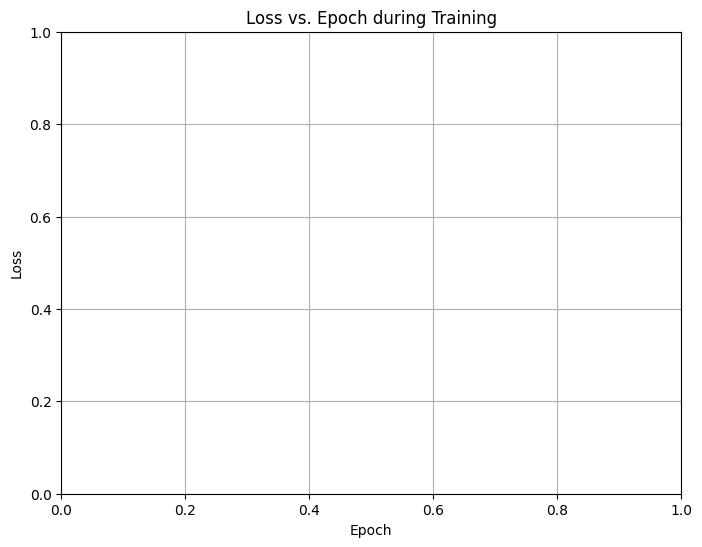

In [5]:
result_path = createResultFolder(osp.join("./results", model_name))
test_best_loss = None
epoch = None

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

Model training

In [6]:
epoch_start = 0 if epoch is None else epoch
epoch = epoch_start
epochs = model_args["epochs"]

for epoch in range(epoch_start + 1, epochs + 1):

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=15)

    # save best model
    if test_best_loss is None or test_loss < test_best_loss:
        test_best_loss = test_loss
        save_model_GCN(epoch, model, optimizer, scheduler, result_path)

    progress_msg = "Epoch " + str(epoch)
    progress_msg += ", train loss(MAE)=" + str(round(train_loss, 4))
    progress_msg += ", valid loss(MAE)=" + str(round(val_loss, 4))
    progress_msg += ", test loss(MAE)=" + str(round(test_loss, 4))
    progress_msg += ", lr=" + str(round(current_lr, 8))
    progress_msg += ", best_test=" + str(round(test_best_loss, 4))

    print(progress_msg)

tensor([[0.0000, 0.3503, 0.0000,  ..., 0.1708, 0.0000, 0.4166],
        [0.0000, 0.3503, 0.0000,  ..., 0.1708, 0.0000, 0.4166],
        [0.0000, 0.3503, 0.0000,  ..., 0.1708, 0.0000, 0.4166],
        ...,
        [1.4153, 0.0000, 0.0000,  ..., 1.8420, 0.0000, 0.6478],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2514],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2514]],
       device='cuda:0', grad_fn=<ReluBackward0>) tensor([[    0,     0,     0,  ..., 27980, 27981, 27982],
        [    2,     4,     5,  ..., 27980, 27981, 27982]], device='cuda:0') tensor([   0,    0,    0,  ..., 1023, 1023, 1023], device='cuda:0') tensor([[3.7711],
        [3.7535],
        [4.0193],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], device='cuda:0')
tensor([[[0.0000, 0.3503, 0.0000,  ..., 0.1708, 0.0000, 0.4166]],

        [[0.0000, 0.3503, 0.0000,  ..., 0.1708, 0.0000, 0.4166]],

        [[0.0000, 0.3503, 0.0000,  ..., 0.1708, 0.0000, 0.4166]],

        ...

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_CUDA__native_batch_norm)

Save model and checkpoint

In [ ]:
checkpoint = torch.load(osp.join(result_path, "checkpoint.pt"),
                        map_location=get_device())

Show results

In [ ]:
best_model = checkpoint["model"]

save_hyper_parameter(args, result_path)
save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
test_loss, test_out, test_y = test_evaluations(best_model, test_loader, test_dataset, device, ret_data=True)

# Reverse normalization of test_out and y
min, max = get_data_scale(args)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print("MAE loss of formation energy is: ", loss.item())

# save results
plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path)
save_regression_result(test_out, test_y, result_path)
plot_regression_result("GCN", result_path, plotfilename="regression_figure.jpeg")